This code is written by [Ali Haghighi](https://hellotherebeautiful.vercel.app/), for the course of remote sensing, Fall 2025 taught by [Dr. Parviz Fatehi](https://profile.ut.ac.ir/en/~parviz.fatehi).


# Relationship Between Vegetation Cover and Land Surface Temperature (LST)

This notebook performs a quantitative analysis of the relationship between vegetation cover (NDVI) and land surface temperature (LST) using the same Landsat 5 TM satellite imagery from Homework 3.

## Overview

The analysis includes:
1. **Load Homework 03 Image** - Same Landsat 5 TM scene (LT51660341987186XXX02)
2. **Convert Reflective Bands to TOA Reflectance** - Red (B3) and NIR (B4) bands
3. **Calculate NDVI** - Normalized Difference Vegetation Index
4. **Recalculate LST** - Land Surface Temperature from thermal Band 6 (reuse HW03 methodology)
5. **Create Vegetation Mask** - Binary mask for vegetated areas (NDVI > 0.35)
6. **Apply Mask** - Restrict analysis to vegetated areas only
7. **Correlation Analysis** - Statistical correlation between NDVI and LST
8. **Visualizations** - NDVI maps, LST maps, masked maps, and scatter plots

## Data Source
- **Satellite**: Landsat 5 Thematic Mapper (TM)
- **Collection**: LANDSAT/LT05/C02/T1 (Collection 2, Tier 1)
- **Scene**: LT51660341987186XXX02 (July 5, 1987)
- **Location**: Path 166, Row 34 (Northern Iran)


## 1. Setup and Imports

Import required libraries and initialize Google Earth Engine.


In [4]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display, Image
import urllib.request
import io
from PIL import Image as PILImage
from scipy.stats import pearsonr

# Authenticate Google Earth Engine
ee.Authenticate()

# Initialize Google Earth Engine
try:
    ee.Initialize(project='surface-hydrology')
    print("✓ Google Earth Engine initialized successfully.")
except Exception as e:
    print(f"Error initializing GEE: {e}")
    print("You may need to run: ee.Authenticate()")
    raise

# Set matplotlib parameters for high-quality plots
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#FF5F05", "#13294B", "#009FD4", "#FCB316", "#006230", "#007E8E", "#5C0E41", "#7D3E13"])


✓ Google Earth Engine initialized successfully.


## 2. Load Scene Information

Load the same Landsat 5 TM scene used in Homework 3.


In [5]:
# Define scene information (same as Homework 3)
scene_id = 'LT51660341987186XXX02'
collection_id = 'LANDSAT/LT05/C02/T1'
date_acquired = '1987-07-05'
cloud_cover = 0

print("=" * 60)
print("SCENE INFORMATION")
print("=" * 60)
print(f"Scene ID: {scene_id}")
print(f"Date Acquired: {date_acquired}")
print(f"Cloud Cover: {cloud_cover}%")
print(f"Collection: {collection_id}")
print("=" * 60)

# Load the specific image from the collection
image = (ee.ImageCollection(collection_id)
         .filter(ee.Filter.eq('LANDSAT_SCENE_ID', scene_id))
         .first())

# Verify the image exists
try:
    image_id = image.get('system:id').getInfo()
    print(f"\n✓ Successfully loaded image: {image_id}")
except Exception as e:
    print(f"Error loading image: {e}")
    raise ValueError("Could not load the image. Please check the scene ID.")

# Get image geometry and native projection
aoi = image.geometry()
native_crs = image.select(0).projection().crs().getInfo()
print(f"Native CRS: {native_crs}")


SCENE INFORMATION
Scene ID: LT51660341987186XXX02
Date Acquired: 1987-07-05
Cloud Cover: 0%
Collection: LANDSAT/LT05/C02/T1

✓ Successfully loaded image: LANDSAT/LT05/C02/T1/LT05_166034_19870705
Native CRS: EPSG:32639


## 3. Convert Reflective Bands to TOA Reflectance

Convert Red (B3) and NIR (B4) bands from digital numbers to Top-of-Atmosphere (TOA) reflectance.


In [6]:
# Extract reflectance metadata parameters
print("Extracting reflectance metadata parameters...")
try:
    refl_mult_b3 = image.get('REFLECTANCE_MULT_BAND_3').getInfo()
    refl_add_b3 = image.get('REFLECTANCE_ADD_BAND_3').getInfo()
    refl_mult_b4 = image.get('REFLECTANCE_MULT_BAND_4').getInfo()
    refl_add_b4 = image.get('REFLECTANCE_ADD_BAND_4').getInfo()
    
    print(f"REFLECTANCE_MULT_BAND_3: {refl_mult_b3}")
    print(f"REFLECTANCE_ADD_BAND_3: {refl_add_b3}")
    print(f"REFLECTANCE_MULT_BAND_4: {refl_mult_b4}")
    print(f"REFLECTANCE_ADD_BAND_4: {refl_add_b4}")
    
except Exception as e:
    print(f"Error extracting metadata: {e}")
    print("Trying alternative property access...")
    props = image.getInfo()['properties']
    refl_mult_b3 = props.get('REFLECTANCE_MULT_BAND_3')
    refl_add_b3 = props.get('REFLECTANCE_ADD_BAND_3')
    refl_mult_b4 = props.get('REFLECTANCE_MULT_BAND_4')
    refl_add_b4 = props.get('REFLECTANCE_ADD_BAND_4')
    
    print(f"REFLECTANCE_MULT_BAND_3: {refl_mult_b3}")
    print(f"REFLECTANCE_ADD_BAND_3: {refl_add_b3}")
    print(f"REFLECTANCE_MULT_BAND_4: {refl_mult_b4}")
    print(f"REFLECTANCE_ADD_BAND_4: {refl_add_b4}")

print()

# Select Red (B3) and NIR (B4) bands
print("Selecting Red (B3) and NIR (B4) bands...")
band3 = image.select('B3')  # Red band
band4 = image.select('B4')  # NIR band

# Convert DN to TOA Reflectance
# Formula: ρ = REFLECTANCE_MULT_BAND_X * DN + REFLECTANCE_ADD_BAND_X
print("Converting DN to TOA reflectance...")
red_reflectance = band3.multiply(refl_mult_b3).add(refl_add_b3).rename('red')
nir_reflectance = band4.multiply(refl_mult_b4).add(refl_add_b4).rename('nir')

# Compute reflectance statistics
red_stats = red_reflectance.reduceRegion(
    reducer=ee.Reducer.percentile([2, 98]),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).getInfo()

nir_stats = nir_reflectance.reduceRegion(
    reducer=ee.Reducer.percentile([2, 98]),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).getInfo()

red_min = red_stats.get('red_p2', 0)
red_max = red_stats.get('red_p98', 1)
nir_min = nir_stats.get('nir_p2', 0)
nir_max = nir_stats.get('nir_p98', 1)

print(f"Red reflectance range: {red_min:.4f} - {red_max:.4f}")
print(f"NIR reflectance range: {nir_min:.4f} - {nir_max:.4f}")
print()


Extracting reflectance metadata parameters...
REFLECTANCE_MULT_BAND_3: 0.0022754
REFLECTANCE_ADD_BAND_3: -0.004825
REFLECTANCE_MULT_BAND_4: 0.002754
REFLECTANCE_ADD_BAND_4: -0.007501

Selecting Red (B3) and NIR (B4) bands...
Converting DN to TOA reflectance...
Red reflectance range: 0.0424 - 0.1931
NIR reflectance range: 0.0303 - 0.3298



## 4. Calculate NDVI

Calculate the Normalized Difference Vegetation Index using reflectance values.


In [7]:
# Calculate NDVI
# NDVI = (NIR - Red) / (NIR + Red)
print("Calculating NDVI = (NIR - Red) / (NIR + Red)...")
ndvi = nir_reflectance.subtract(red_reflectance).divide(
    nir_reflectance.add(red_reflectance)
).rename('ndvi')

# Clip NDVI to valid range (-1 to 1)
ndvi = ndvi.clamp(-1, 1)

# Compute NDVI statistics
ndvi_stats = ndvi.reduceRegion(
    reducer=ee.Reducer.percentile([2, 98]).combine(
        ee.Reducer.minMax(), '', True
    ),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).getInfo()

ndvi_min = ndvi_stats.get('ndvi_min', -1)
ndvi_max = ndvi_stats.get('ndvi_max', 1)
ndvi_p2 = ndvi_stats.get('ndvi_p2', -1)
ndvi_p98 = ndvi_stats.get('ndvi_p98', 1)

print(f"NDVI range: {ndvi_min:.4f} - {ndvi_max:.4f}")
print(f"NDVI 2nd-98th percentile: {ndvi_p2:.4f} - {ndvi_p98:.4f}")
print()


Calculating NDVI = (NIR - Red) / (NIR + Red)...
NDVI range: -1.0000 - 1.0000
NDVI 2nd-98th percentile: -0.2308 - 0.7264



## 5. Recalculate LST (Reuse Homework 3 Methodology)

Calculate Land Surface Temperature using the same methodology from Homework 3.


In [8]:
# Extract thermal metadata parameters
print("Extracting thermal metadata parameters...")
try:
    rad_mult_b6 = image.get('RADIANCE_MULT_BAND_6').getInfo()
    rad_add_b6 = image.get('RADIANCE_ADD_BAND_6').getInfo()
    k1_b6 = image.get('K1_CONSTANT_BAND_6').getInfo()
    k2_b6 = image.get('K2_CONSTANT_BAND_6').getInfo()
    
    print(f"RADIANCE_MULT_BAND_6: {rad_mult_b6}")
    print(f"RADIANCE_ADD_BAND_6: {rad_add_b6}")
    print(f"K1_CONSTANT_BAND_6: {k1_b6}")
    print(f"K2_CONSTANT_BAND_6: {k2_b6}")
    
except Exception as e:
    print(f"Error extracting metadata: {e}")
    props = image.getInfo()['properties']
    rad_mult_b6 = props.get('RADIANCE_MULT_BAND_6')
    rad_add_b6 = props.get('RADIANCE_ADD_BAND_6')
    k1_b6 = props.get('K1_CONSTANT_BAND_6')
    k2_b6 = props.get('K2_CONSTANT_BAND_6')

print()

# Select Band 6 (thermal infrared)
print("Selecting Band 6 (thermal infrared)...")
band6 = image.select('B6')

# Convert DN to Radiance
# Formula: L = RADIANCE_MULT_BAND_6 * B6 + RADIANCE_ADD_BAND_6
print("Converting DN to spectral radiance...")
radiance = band6.multiply(rad_mult_b6).add(rad_add_b6)

# Convert Radiance to Kelvin (with emissivity correction e=0.95)
# Formula: T_kelvin = K2 / ln((K1 * 0.95 / L) + 1)
print("Converting radiance to brightness temperature (Kelvin)...")
print("Using emissivity correction factor: e = 0.95")

k1_img = ee.Image.constant(k1_b6)
k2_img = ee.Image.constant(k2_b6)
emissivity = 0.95

kelvin_temp = k2_img.divide(
    k1_img.multiply(emissivity)
    .divide(radiance)
    .add(1)
    .log()
).rename('temperature')

# Convert Kelvin to Celsius
# Formula: T_celsius = T_kelvin - 273.15
print("Converting Kelvin to Celsius...")
celsius_temp = kelvin_temp.subtract(273.15).rename('lst_celsius')

# Resample LST to 30m to match NDVI resolution
celsius_temp_30m = celsius_temp.resample('bilinear').reproject(
    crs=native_crs,
    scale=30
)

# Compute LST statistics
lst_stats = celsius_temp_30m.reduceRegion(
    reducer=ee.Reducer.percentile([2, 98]),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).getInfo()

lst_p2 = lst_stats.get('lst_celsius_p2', 0)
lst_p98 = lst_stats.get('lst_celsius_p98', 50)

print(f"LST range (Celsius): {lst_p2:.2f} - {lst_p98:.2f} °C")
print()


Extracting thermal metadata parameters...
RADIANCE_MULT_BAND_6: 0.055375
RADIANCE_ADD_BAND_6: 1.18243
K1_CONSTANT_BAND_6: 607.76
K2_CONSTANT_BAND_6: 1260.56

Selecting Band 6 (thermal infrared)...
Converting DN to spectral radiance...
Converting radiance to brightness temperature (Kelvin)...
Using emissivity correction factor: e = 0.95
Converting Kelvin to Celsius...
LST range (Celsius): 24.22 - 46.22 °C



## 6. Create Vegetation Mask

Create a binary mask to identify vegetated areas using NDVI threshold (NDVI > 0.35).


In [9]:
# Create vegetation mask
# Threshold: NDVI > 0.35 indicates vegetated areas
ndvi_threshold = 0.35
print(f"Creating vegetation mask with threshold: NDVI > {ndvi_threshold}")
print("  NDVI > {:.2f} = Vegetated (1)".format(ndvi_threshold))
print("  NDVI <= {:.2f} = Non-vegetated (0)".format(ndvi_threshold))
print()

vegetation_mask = ndvi.gt(ndvi_threshold).rename('vegetation_mask')

# Calculate mask statistics
mask_stats = vegetation_mask.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram().combine(
        ee.Reducer.count(), '', True
    ),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).getInfo()

total_pixels = mask_stats.get('vegetation_mask_count', 0)
histogram = mask_stats.get('vegetation_mask_histogram', {})

vegetated_pixels = histogram.get('1', 0)
non_vegetated_pixels = histogram.get('0', 0)

vegetated_percent = (vegetated_pixels / total_pixels * 100) if total_pixels > 0 else 0
non_vegetated_percent = (non_vegetated_pixels / total_pixels * 100) if total_pixels > 0 else 0

print("Vegetation Mask Statistics:")
print(f"  Total pixels: {total_pixels:,}")
print(f"  Vegetated pixels: {vegetated_pixels:,} ({vegetated_percent:.2f}%)")
print(f"  Non-vegetated pixels: {non_vegetated_pixels:,} ({non_vegetated_percent:.2f}%)")
print()


Creating vegetation mask with threshold: NDVI > 0.35
  NDVI > 0.35 = Vegetated (1)
  NDVI <= 0.35 = Non-vegetated (0)

Vegetation Mask Statistics:
  Total pixels: 38,533,649
  Vegetated pixels: 11,516,005 (29.89%)
  Non-vegetated pixels: 27,017,644 (70.11%)



## 7. Apply Vegetation Mask

Apply the mask to both NDVI and LST layers to restrict analysis to vegetated areas only.


In [10]:
# Apply mask to NDVI and LST
print("Applying vegetation mask to NDVI and LST layers...")
ndvi_masked = ndvi.updateMask(vegetation_mask).rename('ndvi_masked')
lst_masked = celsius_temp_30m.updateMask(vegetation_mask).rename('lst_masked')

print("Mask applied successfully.")
print("Analysis will now focus on vegetated areas only.")
print()


Applying vegetation mask to NDVI and LST layers...
Mask applied successfully.
Analysis will now focus on vegetated areas only.



## 8. Extract Pixel Values and Perform Correlation Analysis

Extract pixel values from masked NDVI and LST layers, then compute statistical correlation.


In [11]:
# Create combined image with both masked NDVI and LST
# Note: Both layers are already masked (only vegetated pixels have values)
combined = ndvi_masked.addBands(lst_masked)

# Sample pixels for correlation analysis
# Using .sample() on masked images will only return unmasked (valid) pixels
print("Sampling pixels from MASKED region (vegetated areas only)...")
print("This may take a few minutes...")

sample_scale = 30  # 30m resolution
sample_size = 10000  # Target sample size

# Sample only from masked (vegetated) areas
sample_points = combined.sample(
    region=aoi,
    scale=sample_scale,
    numPixels=sample_size,
    seed=42,  # For reproducibility
    tileScale=2  # Helps with large images
)

# Extract values
print("Extracting sample values from masked pixels only...")
samples = sample_points.getInfo()['features']

ndvi_values = []
lst_values = []

for sample in samples:
    props = sample.get('properties', {})
    ndvi_val = props.get('ndvi_masked')
    lst_val = props.get('lst_masked')
    
    # Only include valid (non-null) values from masked region
    # Earth Engine's .sample() on masked images should only return valid pixels,
    # but we double-check here to ensure data quality
    if ndvi_val is not None and lst_val is not None:
        ndvi_values.append(ndvi_val)
        lst_values.append(lst_val)

ndvi_array = np.array(ndvi_values)
lst_array = np.array(lst_values)

print(f"Extracted {len(ndvi_array):,} valid pixel pairs")
print(f"NDVI range: {ndvi_array.min():.4f} - {ndvi_array.max():.4f}")
print(f"LST range: {lst_array.min():.2f} - {lst_array.max():.2f} °C")
print()

# Calculate Pearson correlation coefficient
print("Calculating Pearson correlation coefficient...")
correlation_coef, p_value = pearsonr(ndvi_array, lst_array)

print(f"Pearson correlation coefficient (r): {correlation_coef:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Sample size: {len(ndvi_array):,} pixels")
print()

# Interpret correlation strength
if abs(correlation_coef) < 0.3:
    strength = "weak"
elif abs(correlation_coef) < 0.7:
    strength = "moderate"
else:
    strength = "strong"

direction = "negative" if correlation_coef < 0 else "positive"

print(f"Interpretation: {strength.capitalize()} {direction} correlation")
if correlation_coef < 0:
    print("  → Higher vegetation density (NDVI) corresponds to lower surface temperature (LST)")
    print("  → This indicates a cooling effect of vegetation on land surface temperature")
else:
    print("  → Higher vegetation density (NDVI) corresponds to higher surface temperature (LST)")
print()


Sampling pixels for correlation analysis...
This may take a few minutes...
Extracting sample values...
Extracted 2,816 valid pixel pairs
NDVI range: 0.3506 - 0.7785
LST range: 20.32 - 42.12 °C

Calculating Pearson correlation coefficient...
Pearson correlation coefficient (r): -0.6661
P-value: 0.00e+00
Sample size: 2,816 pixels

Interpretation: Moderate negative correlation
  → Higher vegetation density (NDVI) corresponds to lower surface temperature (LST)
  → This indicates a cooling effect of vegetation on land surface temperature



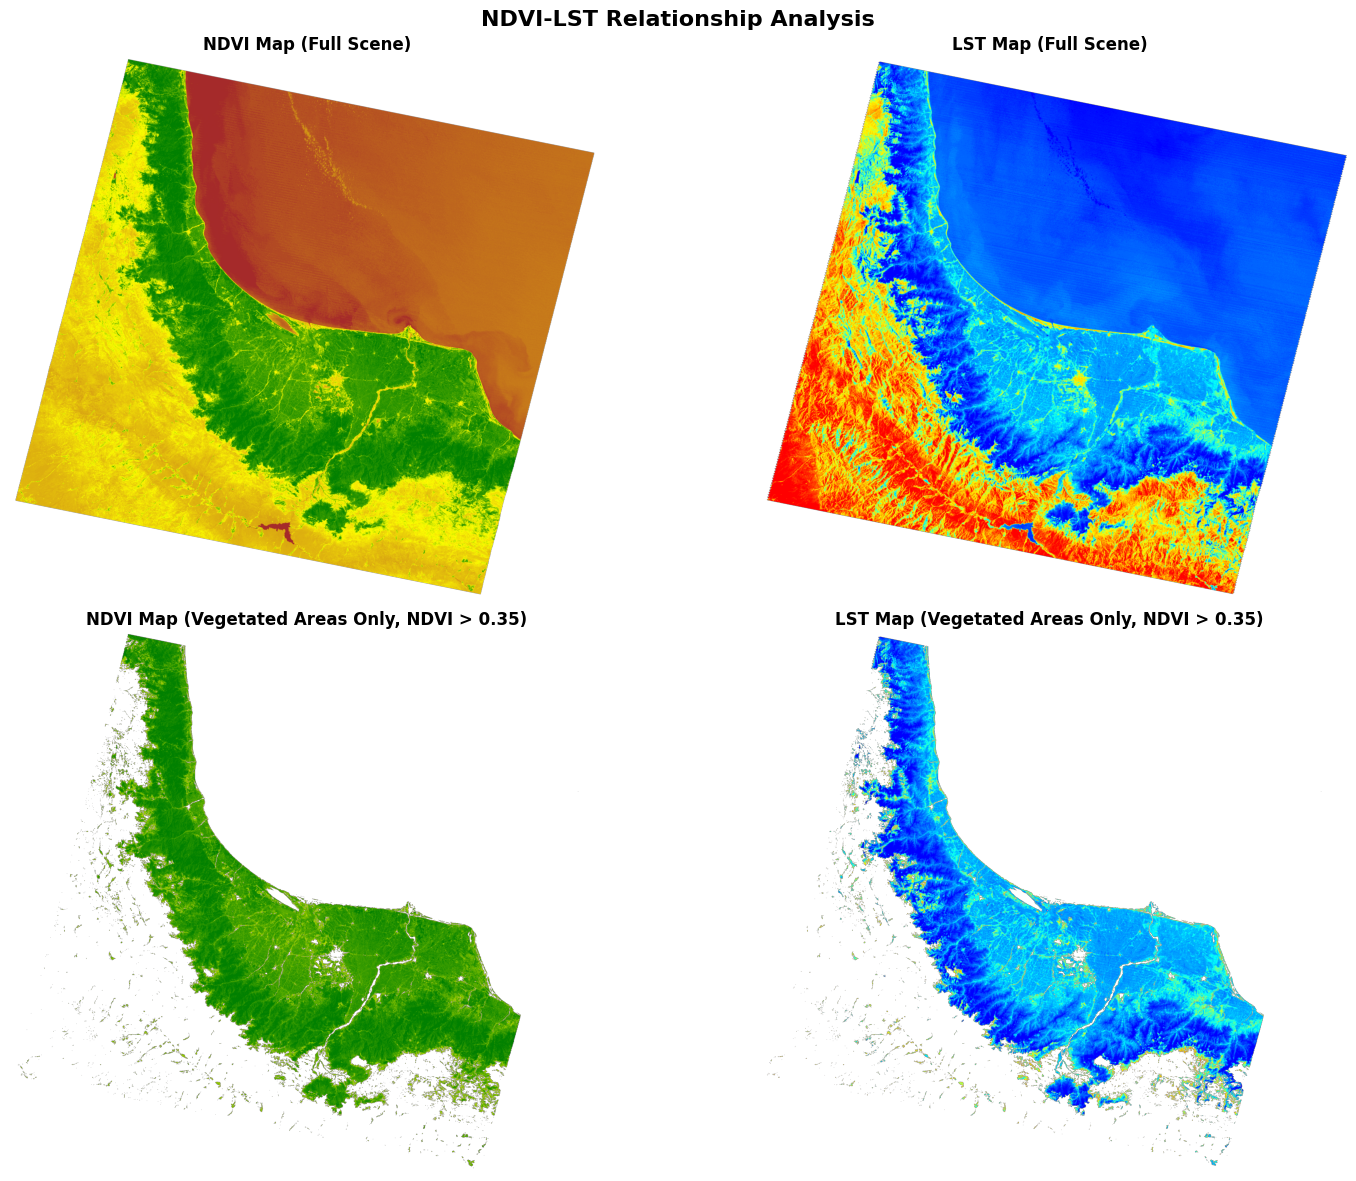

In [12]:
# Create multi-panel figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('NDVI-LST Relationship Analysis', fontsize=16, fontweight='bold', y=0.98)

# Function to download and display image
def download_and_display(image_ee, ax, title, scale=30, max_scale=120):
    """Download and display an Earth Engine image."""
    scales_to_try = [scale, scale * 2, scale * 4, max_scale]
    
    for current_scale in scales_to_try:
        try:
            download_url = image_ee.getDownloadURL({
                'scale': current_scale,
                'crs': native_crs,
                'region': aoi,
                'format': 'PNG'
            })
            
            response = urllib.request.urlopen(download_url)
            img_data = response.read()
            img = PILImage.open(io.BytesIO(img_data))
            
            ax.imshow(img)
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.axis('off')
            return True
            
        except Exception as e:
            if "must be less than or equal to" in str(e):
                if current_scale < max_scale:
                    continue
            return False
    
    return False

# Panel 1: NDVI (full scene)
print("Downloading NDVI map...")
ndvi_vis = ndvi.visualize(min=ndvi_p2, max=ndvi_p98, palette=['brown', 'yellow', 'green'])
download_and_display(ndvi_vis, axes[0, 0], 'NDVI Map (Full Scene)')

# Panel 2: LST (full scene)
print("Downloading LST map...")
lst_vis = celsius_temp_30m.visualize(
    min=lst_p2, max=lst_p98, palette=['blue', 'cyan', 'yellow', 'orange', 'red']
)
download_and_display(lst_vis, axes[0, 1], 'LST Map (Full Scene)')

# Panel 3: Masked NDVI
print("Downloading masked NDVI map...")
ndvi_masked_vis = ndvi_masked.visualize(
    min=ndvi_p2, max=ndvi_p98, palette=['brown', 'yellow', 'green']
)
download_and_display(ndvi_masked_vis, axes[1, 0], 
                     f'NDVI Map (Vegetated Areas Only, NDVI > {ndvi_threshold})')

# Panel 4: Masked LST
print("Downloading masked LST map...")
lst_masked_vis = lst_masked.visualize(
    min=lst_p2, max=lst_p98, palette=['blue', 'cyan', 'yellow', 'orange', 'red']
)
download_and_display(lst_masked_vis, axes[1, 1], 
                     f'LST Map (Vegetated Areas Only, NDVI > {ndvi_threshold})')

plt.tight_layout()
plt.show()

print()


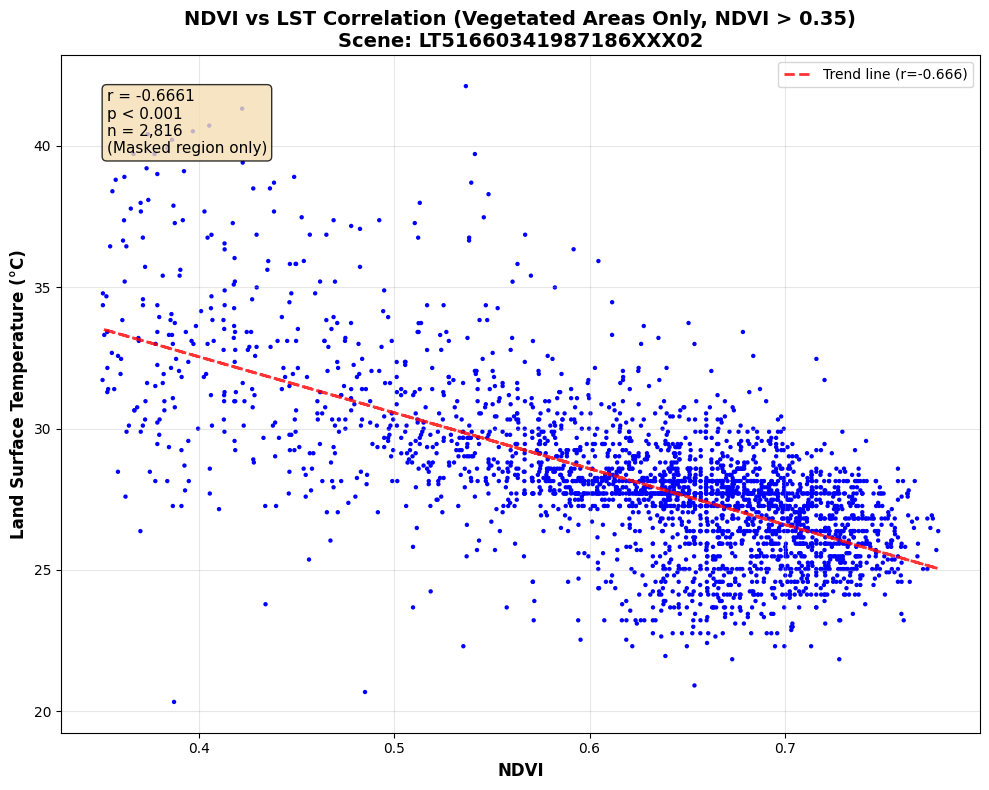


ANALYSIS COMPLETE
Summary:
  Correlation coefficient (r): -0.6661
  Interpretation: Moderate negative correlation
  Sample size: 2,816 pixels (from masked/vegetated region only)
  Vegetated area: 29.89% of scene



In [14]:
# Create scatter plot
# Note: ndvi_array and lst_array contain ONLY pixels from masked (vegetated) region
# These arrays were extracted from ndvi_masked and lst_masked layers
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot - only masked (vegetated) pixels
# Bigger dots, full opacity, no edge
ax.scatter(ndvi_array, lst_array, alpha=1.0, s=10, c='blue', edgecolors='none')

# Add trend line
z = np.polyfit(ndvi_array, lst_array, 1)
p = np.poly1d(z)
ax.plot(ndvi_array, p(ndvi_array), "r--", alpha=0.8, linewidth=2, 
        label=f'Trend line (r={correlation_coef:.3f})')

# Labels and title
ax.set_xlabel('NDVI', fontsize=12, fontweight='bold')
ax.set_ylabel('Land Surface Temperature (°C)', fontsize=12, fontweight='bold')
ax.set_title(f'NDVI vs LST Correlation (Vegetated Areas Only, NDVI > {ndvi_threshold})\nScene: {scene_id}', 
             fontsize=14, fontweight='bold')

# Add correlation info as text
info_text = f'r = {correlation_coef:.4f}\np < 0.001\nn = {len(ndvi_array):,}\n(Masked region only)'
ax.text(0.05, 0.95, info_text, transform=ax.transAxes, 
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.grid(True, alpha=0.3)
ax.legend(loc='best')

plt.tight_layout()
plt.show()

print()
print("=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)
print("Summary:")
print(f"  Correlation coefficient (r): {correlation_coef:.4f}")
print(f"  Interpretation: {strength.capitalize()} {direction} correlation")
print(f"  Sample size: {len(ndvi_array):,} pixels (from masked/vegetated region only)")
print(f"  Vegetated area: {vegetated_percent:.2f}% of scene")
print()
